**Open-loop MPC WITHOUT terminal constraints N = 100**

***Instructions:*** 
- To reproduce results for open-loop EMPC with terminal constraints with varying N, change the value of N (in cell 4) to the (N **+ 1**) of the result being reproduced. For example, if you are simulating results for open-loop MPC with N = 5, update the value of N in cell 4 to N = 6. This is done primarily to resolve plotting issues (plot of input trajectory and cost stop at the second to the last sample period if N is used). 
- In addition to specifying N+1 in cell 4, the user has to specify (N **- 1**) * dt in t_max in cell 14 to avoid plotting issues. 
- To calculate the total economic cost for a length of operation shorter than 5.0 s, the user can extract and sum up the cost history in line 10 for the start and end time step of interest. For example, if the user is interested in summing up the cost for a length of operation of 2.5 s, change print(np.sum(cost_history)) to print(np.sum(cost_history[0:6::])). This adds up the cost from time step 0 to time step 5 (zero-based indexing), which is equivalent to 0.0 to 0.25 s, given that the sample period dt is 0.05.

In [1]:
from casadi import *
import matplotlib.pyplot as plt

In [2]:
def model(x ,u, xs = None, us = None):
    """Compute the right-hand side of the ODEs
    
    Args: 
        x (array-like): State vector
        u (array-like): Input vector
        xs (array-like, optional): steady-state
        us (array-like, optional): steady-state input
    Returns:
        array-like: dx/dt
    """
    if xs is not None:
        # Assume x is in deviation variable form
        x = [x[i] + xs[i] for i in range(1)]
    if us is not None:
        # Assume u is in deviation variable form
        u = [u[i] + us[i] for i in range(1)]
        
    dxdt = [x[0] + u[0]]
    return dxdt

In [3]:
# Get the steady state
us = -3
xs = 3

In [4]:
# Parameters (used in optimal control problem later as well)
N = 101 # specified to make plot of input trajectories and system cost be continuous at t = 5.0
dt = 0.05
T = dt*N

In [5]:
t = SX.sym("t", 1, 1)
x = SX.sym("x", 1, 1)
u = SX.sym("u", 1, 1)
ode = vertcat(*model (x, u))
print(ode, ode.shape)
print(type(ode))

(x+u) (1, 1)
<class 'casadi.casadi.SX'>


![](Casadip6.png)

In [6]:
# Construct an integrating block x_k+1
f = {'x' : x, 't' : t, 'p' : u, 'ode' : ode}
Phi = integrator("Phi", "cvodes", f, {'tf' : dt})

In [7]:
# System Model - in general, the system model
# and the MPC model are different
system = Phi

In [8]:
# Define the decision variable and constraints
q = vertcat(*[MX.sym(f'q{i}', 1, 1) for i in range(N)])
s = vertcat(*[MX.sym(f's{i}', 1, 1) for i in range (N+1)])
z = []
zlb = []
zub = []
constraints = []

# Create a function
cost = 0.
ulb = [-10]
uub = [10]

for i in range(N):
    s_i = s[i: i+1]
    s_ipl = s[i+1:i+2]
    q_i = q[i:i+1]
    
    # Decision variable
    zlb += [-np.inf]
    zlb[0] = 1
    zub += [np.inf]
    zub[0] = 1
    zlb += ulb
    zub += uub
    
    z.append(s_i)
    z.append(q_i)    
    
    xt_ipl = Phi(x0=s_i, p=q_i)['xf']
    cost += 2*(q_i + 10) + (s_i - 2)**2
    constraints.append(xt_ipl - s_ipl)
    
# s_N
z.append(s_ipl)
zlb += [-np.inf]
zub += [np.inf]

constraints = vertcat(*constraints)
variables = vertcat(*z)

#print(variables)
#print(zlb)
#print(len(zlb))

In [9]:
# Create the optimization problem 
g_lb = np.zeros(N)
g_ub = np.zeros(N)
nlp = {'f' : cost, 'g': constraints, 'x': variables}
opt = {'print_time': 0, 'ipopt.print_level':0}
solver = nlpsol('solver', 'ipopt', nlp, opt)

def solve_empc(): 
    """Solve EMPC provided x
    
    Args:
        x  (array-like): current state
    Returns:
        typle: current input and return status pair
    """ 
    sol_out = solver(lbx=zlb, ubx=zub, lbg=g_lb, ubg=g_ub)
    return sol_out

In [10]:
sol_out = solve_empc()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [11]:
state_history = sol_out['x'][0::2]

input_history = sol_out['x'][1::2]

In [12]:
def stage_cost(x,u):
    return float(2*(u + 10) + (x - 2)**2)

In [13]:
cost_history = [stage_cost(state_history[i], input_history[i]) for i in range(N)]
print(np.sum(cost_history))

time = [i*dt for i in range(N+1)]

1470.814719342651


<Figure size 1008x1008 with 0 Axes>

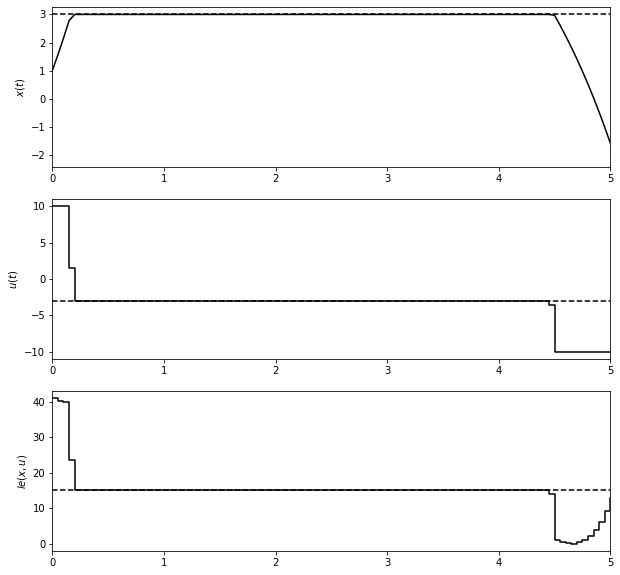

In [14]:
# Figure
cost_ss = [15]
plt.figure(figsize=[14,14])
fig, axs = plt.subplots(3, 1, figsize=[10,10])
t_max = min(10, (N-1)*dt)
for j in range(1):
    axs[j].plot(time, state_history[:, j], 'k-',
                [time[0], time[-1]], [xs, xs], 'k--')
    axs[j].set_ylabel(f'$x(t)$')
    axs[j].set_xlim([0, t_max])
    
for j in range(1):
    axs[j+1].step(time[:-1], input_history[:, j], 'k-',
                  [time[0], time[-1]], [us,us], 'k--',
                  where='post')
    axs[j+1].set_ylabel(f'$u(t)$')
    axs[j+1].set_xlim([0, t_max])
    
for j in range(1):
    axs[j+2].step(time[:-1], cost_history, 'k-',
                  [time[0], time[-1]], [cost_ss,cost_ss], 'k--',
                  where='post')
    axs[j+2].set_ylabel(f'$le(x,u)$')
    axs[j+2].set_xlim([0, t_max])
    
plt.savefig('OLWT100.png')

**Open-loop MPC WITHOUT terminal constraints N = 100**